In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
args = type('', (), {})() # Google "creating an empty object in Python"
args.cuda = torch.cuda.is_available()
args.batch_size = 128
args.epochs = 5
args.seed = 1
args.log_interval = 50 # how many batches to wait before logging training status

args.lr = 0.01
args.momentum = 0.5

In [4]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False, **kwargs)

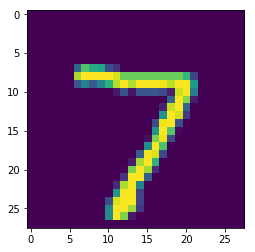

In [6]:
def get_test_img(ind=0):
    batch_idx, (data, ys) = next(enumerate(test_loader))
    test_img = Variable(data[ind:ind+1])
    return test_img

def show_test_img(ind=0):
    plt.imshow(get_test_img(ind).view(28,28).data)
    
def show_img(img):
    plt.imshow(img.view(28,28).data)
    
show_test_img()

This is classic Conv Mnist. 95%.

In [7]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

# model = Net()
# if args.cuda:
#     model.cuda()

# optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# def train(epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data[0]))

# def test():
#     model.eval()
#     test_loss = 0
#     correct = 0
#     for data, target in test_loader:
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data, volatile=True), Variable(target)
#         output = model(data)
#         test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
#         pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#         correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

#     test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))


# for epoch in range(1, args.epochs + 1):
#     train(epoch)
#     test()

This is 1 FC layer Mnist. 90%

In [8]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc = nn.Linear(28*28, 10)

#     def forward(self, x):
#         x = self.fc(x)
#         return F.log_softmax(x, dim=-1).squeeze()

# model = Net()
# if args.cuda:
#     model.cuda()

# optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# def train(epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
#         data = data.view(data.shape[0], data.shape[1], 28*28)
#         data, target = Variable(data), Variable(target)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data[0]))

# def test():
#     model.eval()
#     test_loss = 0
#     correct = 0
#     for data, target in test_loader:
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
#         data = data.view(data.shape[0], data.shape[1], 28*28)
#         data, target = Variable(data, volatile=True), Variable(target)
#         output = model(data)
#         test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
#         pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#         correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

#     test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))


# for epoch in range(1, args.epochs + 1):
#     train(epoch)
#     test()

In [9]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [10]:
class Net(nn.Module):
    def __init__(self, n_bits=3, hidden_size=128):
        super(Net, self).__init__()
        
        t0 = nn.Linear(28*28, hidden_size) # input layer
        _ts = [t0]
        for i in range(1, n_bits):
            _ts.append(nn.Linear(hidden_size, hidden_size))
        self.ts = nn.ModuleList(_ts)
        
        _os = []
        for i in range(n_bits):
            _os.append(nn.Linear(hidden_size, 2))
        self.os = nn.ModuleList(_os)
        
        self.decoder = nn.Linear(2*n_bits, 10)
        self.relu = nn.ReLU()
        self.n_bits = n_bits
        
    def forward(self, x):
        inp = x
        
        oh = [] # one-hot's
        for i in range(self.n_bits):
            hid = self.ts[i](inp)
            out = self.os[i](hid)
            oh.append(gumbel_softmax(out, temperature=1.))
            inp = self.relu(hid) # next layer's input
        
        bits = torch.cat(oh, dim=-1) # each "bit" is actually (0,1) or (1,0)
        res = self.decoder(bits)
        return F.log_softmax(res, dim=-1).squeeze()

model = Net(n_bits=2, hidden_size=128)
if args.cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data = data.view(data.shape[0], data.shape[1], 28*28)
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 50 + 1):
    print(epoch)
    train(epoch)
    test()

1

Test set: Average loss: 2.2902, Accuracy: 1326/10000 (13%)

2

Test set: Average loss: 2.2001, Accuracy: 2051/10000 (21%)

3

Test set: Average loss: 2.1094, Accuracy: 2214/10000 (22%)

4

Test set: Average loss: 2.0201, Accuracy: 2526/10000 (25%)

5

Test set: Average loss: 1.9134, Accuracy: 2840/10000 (28%)

6

Test set: Average loss: 1.8339, Accuracy: 2908/10000 (29%)

7

Test set: Average loss: 1.7639, Accuracy: 2923/10000 (29%)

8

Test set: Average loss: 1.7083, Accuracy: 2955/10000 (30%)

9

Test set: Average loss: 1.6676, Accuracy: 3068/10000 (31%)

10

Test set: Average loss: 1.6384, Accuracy: 3099/10000 (31%)

11

Test set: Average loss: 1.6068, Accuracy: 3093/10000 (31%)

12

Test set: Average loss: 1.5835, Accuracy: 3125/10000 (31%)

13

Test set: Average loss: 1.5672, Accuracy: 3168/10000 (32%)

14

Test set: Average loss: 1.5657, Accuracy: 3220/10000 (32%)

15

Test set: Average loss: 1.5365, Accuracy: 3423/10000 (34%)

16

Test set: Average loss: 1.5188, Accuracy: 345

In [11]:
#0123456789
#1234567 8
#0.6*1 + 0.4*0.5 = 0.8 is optimal for 3 bits